# **Introduction**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this notebook a machine learning model has been built that predicts which Tweets are about real disasters and which one’s aren’t. 

# **Setting up the environment**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Library for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

#Libraries for Natural Language Processing NLTK stands for Natural Language Toolkit
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import TweetTokenizer
from wordcloud import WordCloud

#Libraries for Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,plot_confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#  **Preparation of Training Data**

In [ ]:
#importing training data file
train_data= pd.read_csv("../input/nlp-getting-started/train.csv")
train_data.head()

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

# **Data Cleaning**

**Checking for Null Values**

In [ ]:
#Checking columns with missing data
Miss_Percent=100*(train_data.isnull().sum()/len(train_data))

#Sorting the data columns by their percentage in descending order
Miss_Percent=Miss_Percent[Miss_Percent>0].sort_values(ascending=False).round(1)

#Creating a dataframe to show percentage of missing data and its respective data column in table
DataFrame=pd.DataFrame(Miss_Percent)
miss_percent_table=DataFrame.rename(columns={0:'% of Missing Values'})
MissPercent=miss_percent_table

#Displaying Missing Value table
MissPercent

**Filling Null values with appropriate values**

In [ ]:
train_data['keyword'].unique()

In [ ]:
#Replacing Null value in Keyword with None
train_data['keyword']=train_data['keyword'].fillna('None')

In [ ]:
train_data['location'].unique()

In [ ]:
#Replacing Null value in location with Unavailable
train_data['location']=train_data['location'].fillna('Unavailable')

In [ ]:
#Dropping ID as it is irrelevant for classification
train_data=train_data.drop('id',axis=1)

In [ ]:
train_data.head()

# **Explanatory Data Analysis**

In [ ]:
sns.countplot(data=train_data,x='target')

In [ ]:
#Common words used in Disaster Tweets
data_disaster_nl = ' '.join(list(train_data[train_data['target'] == 1]['text']))
data_wc_nl = WordCloud(width = 600, height = 512).generate(data_disaster_nl)
plt.figure(figsize = (13, 9))
plt.imshow(data_wc_nl)
plt.show()

In [ ]:
#Common words used in Non-Disaster Tweets
data_non_disaster_nl = ' '.join(list(train_data[train_data['target'] == 0]['text']))
data_wc_nd_nl = WordCloud(width = 600, height = 512).generate(data_non_disaster_nl)
plt.figure(figsize = (13, 9))
plt.imshow(data_wc_nd_nl)
plt.show()

## **Data Preprocessing**

Now, Lemmatization is conducted. Lemmatization reduces a word form to its initial dictionary form (lemma). As a result of word forms lemmatization, flexive endings are discarded and the main or dictionary form of the word is returned.

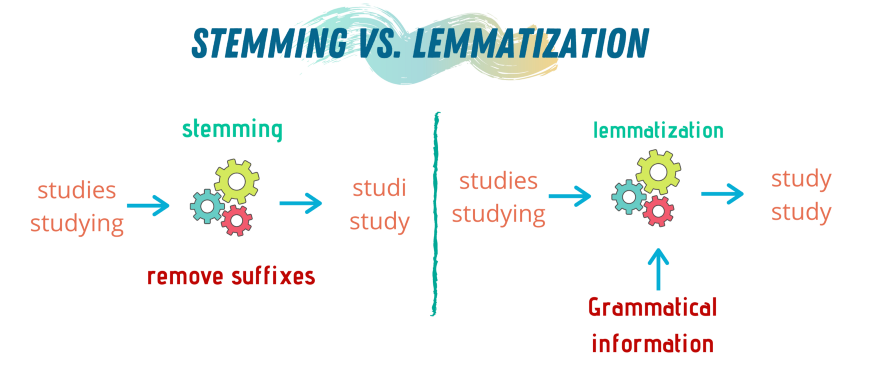!

Tokenization is process of breaking complex data into smaller units as tokens. It can be done by splitting paragraphs into sentences and sentences into words.

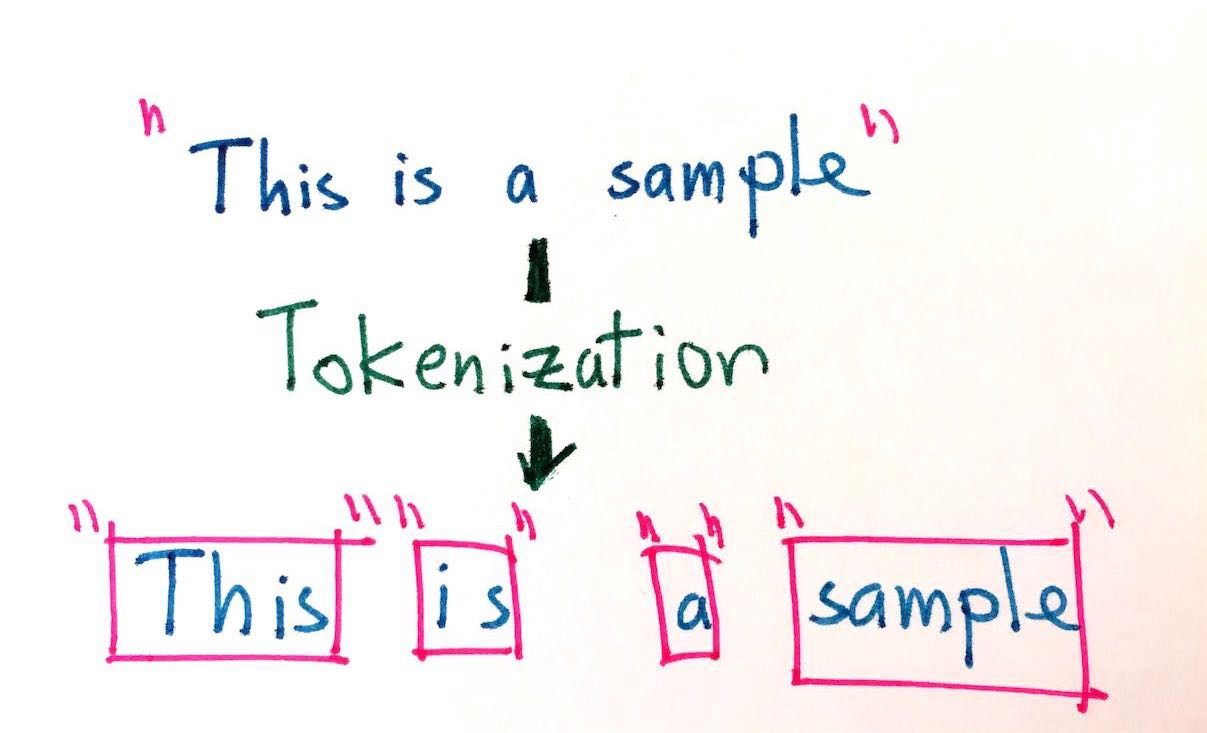

In [ ]:
#Tokenization Process
tokenizer = TweetTokenizer()

tokens = [tokenizer.tokenize(word) for word in train_data['text']]
train_data = train_data.assign(tokens = tokens)

train_data

In [ ]:
#Lemmatization Process
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Turn tokens into lemmatized/stemmed strings
def lemmatize_stem_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        x = stemmer.stem(x)
        new_item.append(x)
    return " ".join(new_item)

In [ ]:
#if the tweets are not steemed then this if statement filters that help complete the stemming process
if not 'stemmed' in train_data:
    train_data.tokens = [lemmatize_stem_item(item) for item in train_data.tokens]
    train_data['stemmed'] = True

train_data

Data needs to be converted into a numerical format where each word is represented by a matrix known as Vectorization.

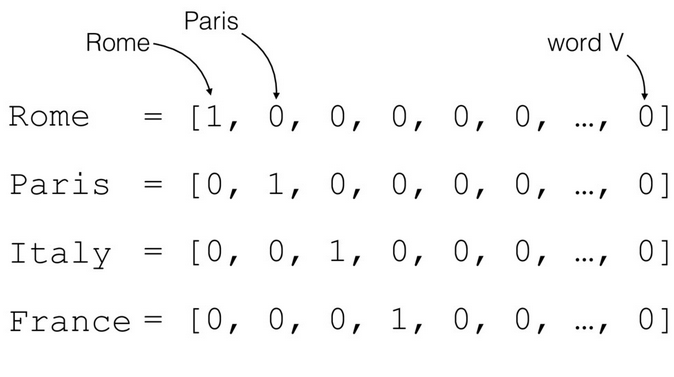

In [ ]:
vectorizer = CountVectorizer()

train_x_vectors = vectorizer.fit_transform(train_data.tokens)
train_x_vectors

Changing the data into X and y for prepare for training the ML models

In [ ]:
X=train_x_vectors
y=train_data['target']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)
print('Number of rows in training set: ' + str(X_train.shape))
print('Number of rows in validation set: ' + str(X_val.shape))

# **Classification Models**

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
class_LR = LogisticRegression(random_state = 42, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_val)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
class_rep_LR = classification_report(y_val, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_confusion_matrix(class_LR, X_val, y_val) 
plt.show()

**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
class_SVC = SVC(probability = True, random_state = 42).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_val)
print('The first two predicted labels:', y_pred_SVC[0], y_pred_SVC[1], '\n')
class_rep_SVC = classification_report(y_val, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')
plot_confusion_matrix(class_SVC, X_val, y_val) 
plt.show()

# **Preparing Test Data**

In [ ]:
test_data=pd.read_csv("../input/nlp-getting-started/test.csv")
test_data.head()

In [ ]:
def extract_data(df):

    df['tokens'] = [tokenizer.tokenize(item) for item in df.text]
    df['tokens'] = [lemmatize_stem_item(item) for item in df.tokens]
    vectors = vectorizer.transform(df.tokens)
    
    return vectors

# **Predicting using SVM in Test Data**

In [ ]:
test_pred_SVM=class_SVC.predict(extract_data(test_data))

# **Submitting the test results**

In [ ]:
submission = pd.DataFrame(test_data.id)
submission['target'] = test_pred_SVM
submission

In [ ]:
submission.to_csv("Tweet_Prediction.csv",index=False)
print("Completed")

> **Thank you for visiting this notebook. If you liked it, please upvote it.**